In [1]:
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
%pylab inline

import pickle as pkl
from itertools import islice
import datetime
import random
import itertools
import glob
import pickle as pkl
import time
import os
import fancyimpute, impyute

# from keras.models import Sequential
# from keras.layers import LSTM, Masking, Dense, RepeatVector, TimeDistributed


from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input
from keras.optimizers import SGD
from keras.utils import plot_model

from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

rootPath = '../IMDA/'


Populating the interactive namespace from numpy and matplotlib


/Users/phuw273g/.local/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


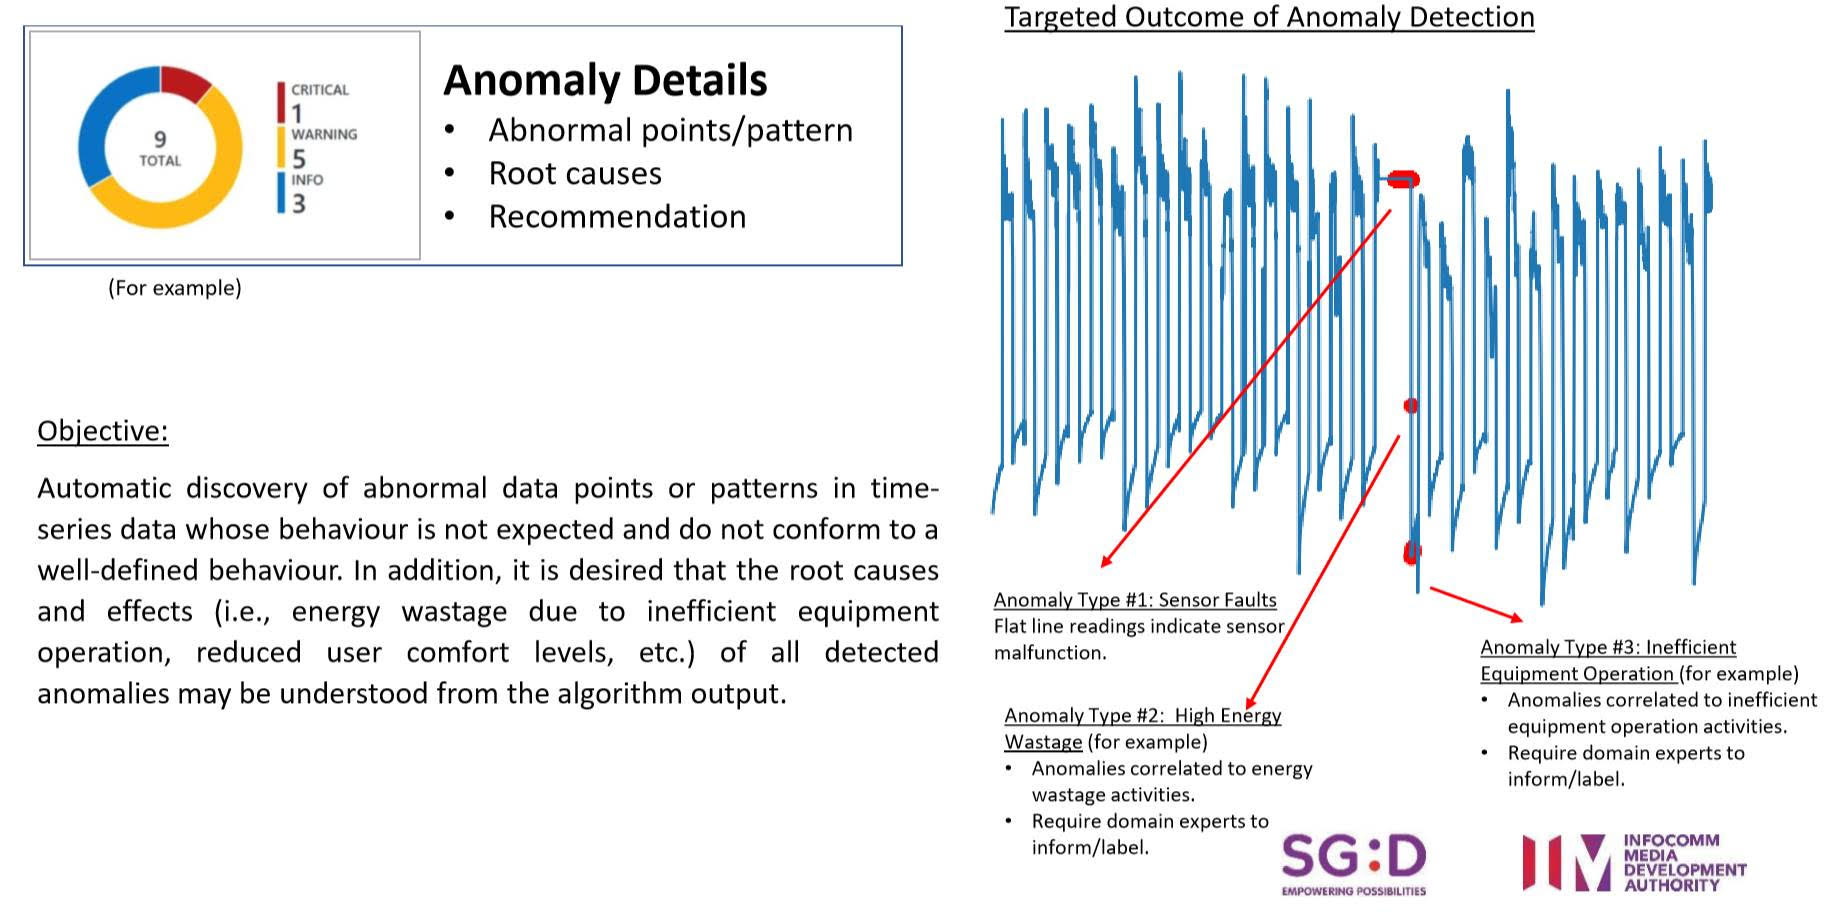

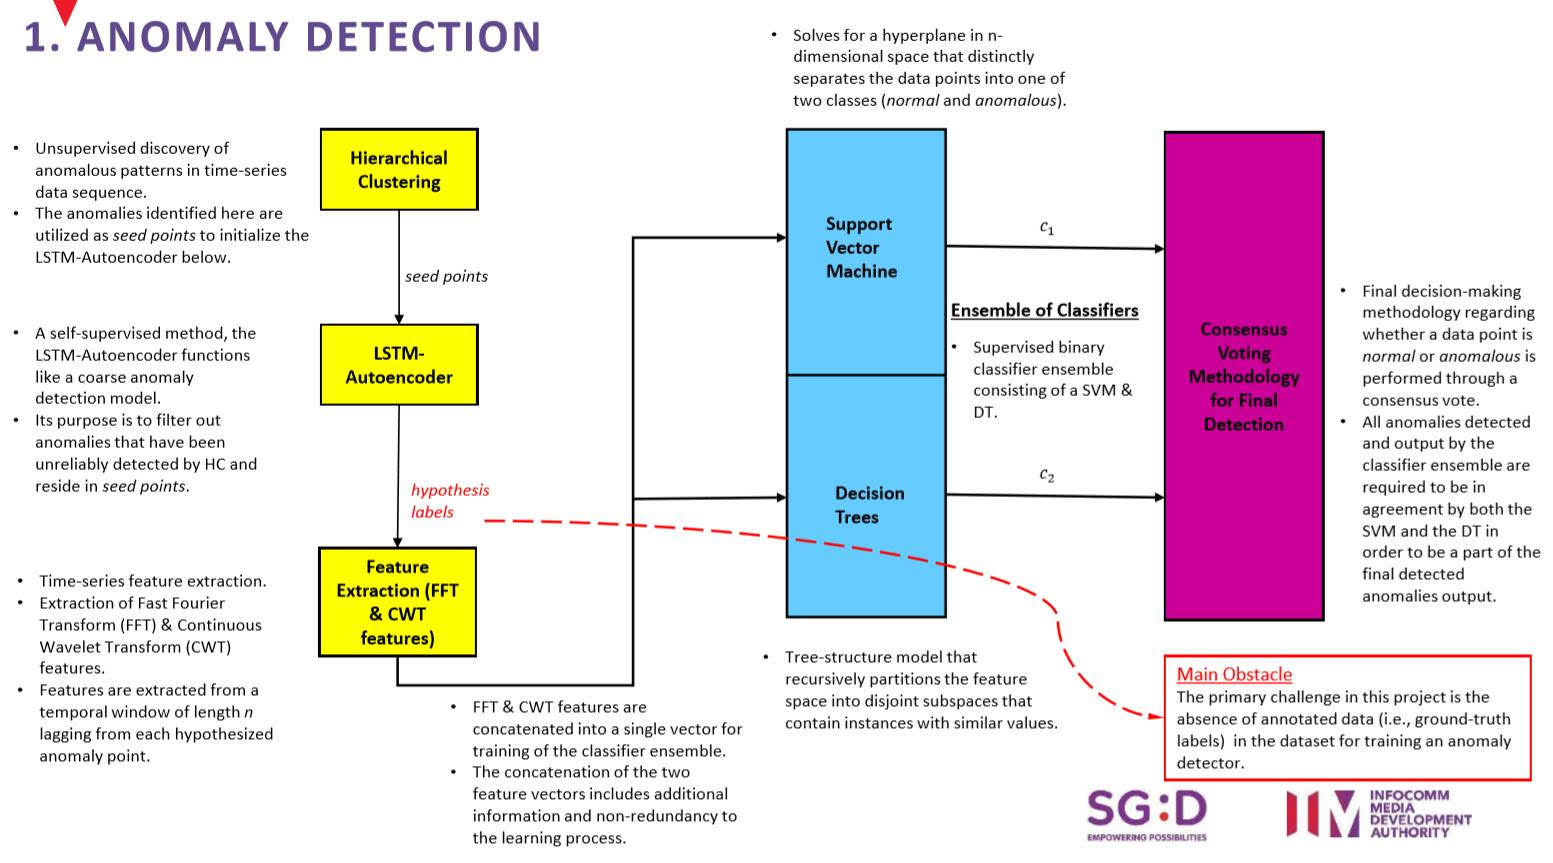

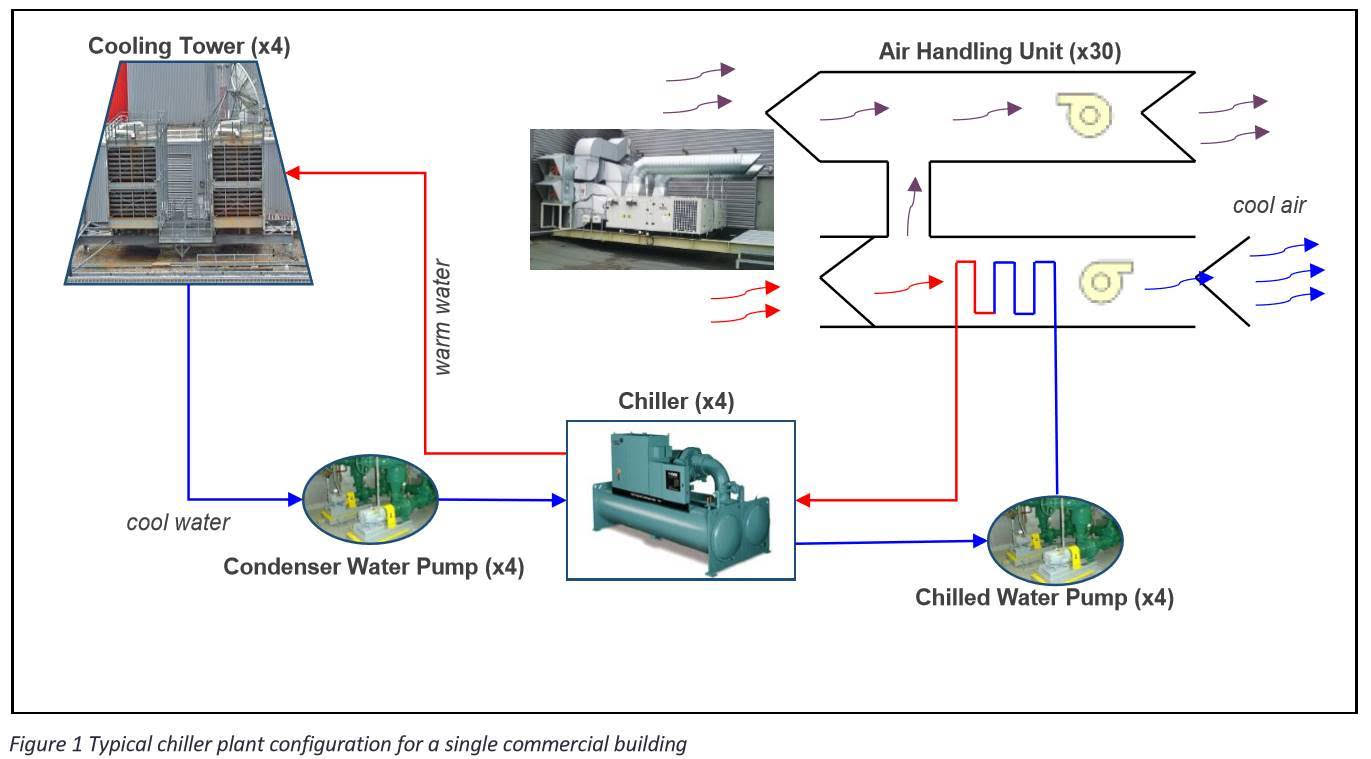
## Columns meaning:
 - CWRT: Condenser Water Return Temperature
 - HLI Entering CHW Temp: High Level Interface Entering (Return) Chilled Water Temperature

__*Anomaly Types*__ <br>
1. sensor fault
2. high energy wastage anomaly
3. inefficient equipment operation anomaly

In [2]:
def chopts(df_, cols, nts=int(24*60/5), overlapts=int(24*60/5)-1):
    # assume df_.index has no missing timestamps
    df = df_.copy()
    allts = list(df.index)
    allts.sort()
    ind = [j*(nts-overlapts) for j in range(int(len(allts)/(nts-overlapts)))]
    tsgrp = []
    for i in ind:
        tmp = allts[i: i+nts]
        if len(tmp) == nts:
            tsgrp.append(tmp)
    
    result = pd.DataFrame({'data': [df.loc[df.index.isin(tsgrp[i]), cols] for i in range(len(tsgrp))], 
                           'from': [tsgrp[i][0] for i in range(len(tsgrp))], 
                           'to': [tsgrp[i][-1] for i in range(len(tsgrp))]})
    return result


## Read Data

In [3]:
maincols = ['CWRT_syth', 'HLI Entering CHW Temp']
timecols=['weekday', 'hourminute']
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

In [4]:
data_impute = pd.read_csv(rootPath+'data_2_modified_clean_impute.csv', 
                          index_col='Unnamed: 0', date_parser=dateparse)
print(data_impute.shape)
print(data_impute.dtypes)
print(min(data_impute.index), max(data_impute.index))
display(data_impute.head())


(17719, 17)
Date                                                object
Time                                                object
CWRT_syth                                          float64
HLI Entering CHW Temp                              float64
LABEL_(CWRT_syth)_(wrong_gap)                         bool
LABEL_(HLI Entering CHW Temp)_(wrong_gap)             bool
day                                                  int64
weekday                                              int64
hourminute                                           int64
LABEL_(CWRT_syth)_(extreme_value)                     bool
LABEL_(HLI Entering CHW Temp)_(extreme_value)         bool
LABEL_(CWRT_syth_profile)_(outlier)                   bool
LABEL_(HLI Entering CHW Temp_profile)_(outlier)       bool
CWRT_syth_leave_empty                                 bool
CWRT_syth_fill_median                                 bool
HLI Entering CHW Temp_leave_empty                     bool
HLI Entering CHW Temp_fill_median           

,Date,Time,CWRT_syth,HLI Entering CHW Temp,LABEL_(CWRT_syth)_(wrong_gap),LABEL_(HLI Entering CHW Temp)_(wrong_gap),day,weekday,hourminute,LABEL_(CWRT_syth)_(extreme_value),LABEL_(HLI Entering CHW Temp)_(extreme_value),LABEL_(CWRT_syth_profile)_(outlier),LABEL_(HLI Entering CHW Temp_profile)_(outlier),CWRT_syth_leave_empty,CWRT_syth_fill_median,HLI Entering CHW Temp_leave_empty,HLI Entering CHW Temp_fill_median
2019-01-13 00:00:00,2019-01-13,0000h,31.090000,11.700000,False,False,13,7,0,False,False,False,False,False,False,False,True
2019-01-13 00:05:00,2019-01-13,0005h,31.106000,11.100000,False,False,13,7,5,False,False,False,False,False,False,False,True
2019-01-13 00:10:00,2019-01-13,0010h,31.129999,10.600000,False,False,13,7,10,False,False,False,False,False,False,False,False
2019-01-13 00:15:00,2019-01-13,0015h,31.146000,10.633334,False,False,13,7,15,False,False,False,False,False,False,False,False
2019-01-13 00:20:00,2019-01-13,0020h,31.170000,10.666667,False,False,13,7,20,False,False,False,False,False,False,False,False


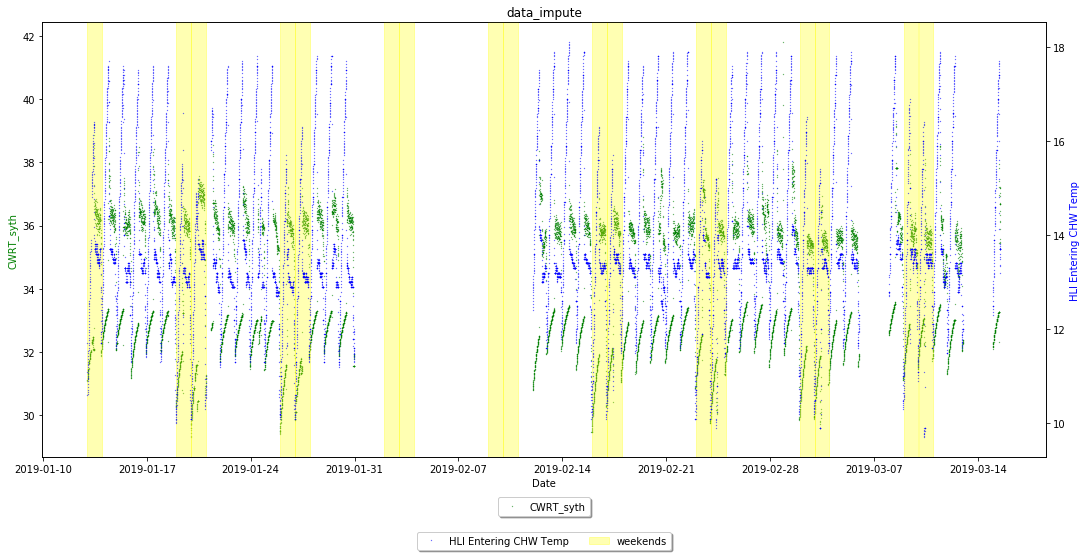

In [5]:
# plot
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))

ax1.plot_date(data_impute.index, data_impute['CWRT_syth'], 
              c='g', markersize=0.5, marker='.', linewidth=1, linestyle='', label='CWRT_syth')
ax1.set_ylabel('CWRT_syth', color='g')
ax1.set_xlabel('Date')

ax2.plot_date(data_impute.index, data_impute['HLI Entering CHW Temp'], 
              c='b', markersize=0.5,  marker='.', linewidth=1, linestyle='', label='HLI Entering CHW Temp')
ax2.set_ylabel('HLI Entering CHW Temp', color='b')

tmp = data_impute.index.to_frame()
tmp['wkday'] = data_impute.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
i = 0
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    if i == len(allwknddate)-1:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow', label='weekends')
    else:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow')
    i += 1
       
plt.title('data_impute')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16),fancybox=True, shadow=True, ncol=5)
plt.show()


In [6]:
#------------------ min max scaling--------------------------
data_impute_scale = data_impute.copy()
scaler = MinMaxScaler()
scaler.fit(data_impute_scale[maincols+timecols])
data_impute_scale[maincols+timecols] = scaler.transform(data_impute_scale[maincols+timecols])

print(data_impute_scale.shape)
display(data_impute_scale.head())

(17719, 17)


,Date,Time,CWRT_syth,HLI Entering CHW Temp,LABEL_(CWRT_syth)_(wrong_gap),LABEL_(HLI Entering CHW Temp)_(wrong_gap),day,weekday,hourminute,LABEL_(CWRT_syth)_(extreme_value),LABEL_(HLI Entering CHW Temp)_(extreme_value),LABEL_(CWRT_syth_profile)_(outlier),LABEL_(HLI Entering CHW Temp_profile)_(outlier),CWRT_syth_leave_empty,CWRT_syth_fill_median,HLI Entering CHW Temp_leave_empty,HLI Entering CHW Temp_fill_median
2019-01-13 00:00:00,2019-01-13,0000h,0.143291,0.238095,False,False,13,1.0,0.000000,False,False,False,False,False,False,False,True
2019-01-13 00:05:00,2019-01-13,0005h,0.144571,0.166667,False,False,13,1.0,0.003484,False,False,False,False,False,False,False,True
2019-01-13 00:10:00,2019-01-13,0010h,0.146490,0.107143,False,False,13,1.0,0.006969,False,False,False,False,False,False,False,False
2019-01-13 00:15:00,2019-01-13,0015h,0.147769,0.111111,False,False,13,1.0,0.010453,False,False,False,False,False,False,False,False
2019-01-13 00:20:00,2019-01-13,0020h,0.149688,0.115079,False,False,13,1.0,0.013937,False,False,False,False,False,False,False,False


In [8]:
#------------ sampling from sequence --------------------
number_ts = int(3*60/5)  #int(24*60/5)

data_impute_scale_daily = chopts(
    data_impute_scale, maincols+timecols, nts=number_ts, overlapts=number_ts-1)

data_impute_scale_daily['shape'] = data_impute_scale_daily['data'].apply(lambda x: x.shape)
for col in maincols:
    data_impute_scale_daily[col+'_missing'] = data_impute_scale_daily[
        'data'].apply(lambda x: len(x[x[col].isna()]) / len(x))

print(min(data_impute_scale_daily['from']), max(data_impute_scale_daily['from']))
print(min(data_impute_scale_daily['to']), max(data_impute_scale_daily['to']))
print(data_impute_scale_daily.shape)
display(data_impute_scale_daily.describe())
display(data_impute_scale_daily.head())

2019-01-13 00:00:00 2019-03-15 09:35:00
2019-01-13 02:55:00 2019-03-15 12:30:00
(17684, 6)


,CWRT_syth_missing,HLI Entering CHW Temp_missing
count,17684.000000,17684.000000
mean,0.268298,0.267643
std,0.438261,0.438965
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


,data,from,to,shape,CWRT_syth_missing,HLI Entering CHW Temp_missing
0,CWRT_syth HLI Entering C...,2019-01-13 00:00:00,2019-01-13 02:55:00,"(36, 4)",0.166667,0.0
1,CWRT_syth HLI Entering C...,2019-01-13 00:05:00,2019-01-13 03:00:00,"(36, 4)",0.166667,0.0
2,CWRT_syth HLI Entering C...,2019-01-13 00:10:00,2019-01-13 03:05:00,"(36, 4)",0.166667,0.0
3,CWRT_syth HLI Entering C...,2019-01-13 00:15:00,2019-01-13 03:10:00,"(36, 4)",0.166667,0.0
4,CWRT_syth HLI Entering C...,2019-01-13 00:20:00,2019-01-13 03:15:00,"(36, 4)",0.166667,0.0


In [9]:
data_impute_scale_daily_nomissing = data_impute_scale_daily[
    (data_impute_scale_daily['CWRT_syth_missing']==0)&
    (data_impute_scale_daily['HLI Entering CHW Temp_missing']==0)].copy()

print(data_impute_scale_daily_nomissing.shape, 
      data_impute_scale_daily_nomissing.shape)
display(data_impute_scale_daily_nomissing.head())

(12660, 6) (12660, 6)


,data,from,to,shape,CWRT_syth_missing,HLI Entering CHW Temp_missing
30,CWRT_syth HLI Entering C...,2019-01-13 02:30:00,2019-01-13 05:25:00,"(36, 4)",0.0,0.0
86,CWRT_syth HLI Entering C...,2019-01-13 07:10:00,2019-01-13 10:05:00,"(36, 4)",0.0,0.0
87,CWRT_syth HLI Entering C...,2019-01-13 07:15:00,2019-01-13 10:10:00,"(36, 4)",0.0,0.0
88,CWRT_syth HLI Entering C...,2019-01-13 07:20:00,2019-01-13 10:15:00,"(36, 4)",0.0,0.0
89,CWRT_syth HLI Entering C...,2019-01-13 07:25:00,2019-01-13 10:20:00,"(36, 4)",0.0,0.0


In [10]:
tmp = data_impute_scale_daily_nomissing.copy()
cond = tmp['shape']==tmp['shape'].value_counts(ascending=False).index[0]

data_x = {}
data_x['combine'] = np.stack(list(tmp.loc[cond, 'data'].apply(lambda x: x[maincols+timecols].values)))
print(data_x['combine'].shape)
display(data_x['combine'])

(12660, 36, 4)


array([[[0.18535096, 0.27248682, 1.        , 0.10452962],
        [0.18726999, 0.27910058, 1.        , 0.10801394],
        [0.18726999, 0.28571433, 1.        , 0.11149826],
        ...,
        [0.21653594, 0.48412698, 1.        , 0.2195122 ],
        [0.21845497, 0.49206352, 1.        , 0.22299652],
        [0.21973439, 0.50000006, 1.        , 0.22648084]],

       [[0.23684635, 0.60714286, 1.        , 0.29965157],
        [0.23924516, 0.61507936, 1.        , 0.30313589],
        [0.23924516, 0.62301586, 1.        , 0.30662021],
        ...,
        [0.22165351, 0.77380958, 1.        , 0.41463415],
        [0.22165351, 0.77777785, 1.        , 0.41811847],
        [0.22165351, 0.78174612, 1.        , 0.42160279]],

       [[0.23924516, 0.61507936, 1.        , 0.30313589],
        [0.23924516, 0.62301586, 1.        , 0.30662021],
        [0.23924516, 0.63095236, 1.        , 0.31010453],
        ...,
        [0.22165351, 0.77777785, 1.        , 0.41811847],
        [0.22165351, 0.781746

In [11]:
# check for nan
for k in data_x.keys():
    tmp = data_x[k]
    print(tmp[np.isnan(tmp)])

[]


## Autoencoder

In [12]:
def getpredict(model, dataarray):
    tmp = dataarray.reshape(1, dataarray.shape[0], dataarray.shape[1])
    return model.predict(tmp)

def calpredtruediff(predarray, truearray, colsind):
    true = truearray[:, colsind]
    pred = predarray.reshape(predarray.shape[1])
    return (true-pred)
    

In [15]:
darray.shape

(12660, 36, 4)

### __*combined features*__

In [16]:
col = 'combine'
#darray = data_x[col][:, :, [0, 1]]

darray = data_x[col][:, :, :]  # include the time features

visible = Input(shape=(darray.shape[1], darray.shape[2]))
encoder = LSTM(200, activation='relu')(visible)
# define reconstruct decoder
decoder1 = RepeatVector(data_x[col].shape[1])(encoder)
decoder1 = LSTM(200, activation='relu', return_sequences=True)(decoder1)
#decoder1 = TimeDistributed(Dense(darray.shape[2]))(decoder1)
decoder1 = TimeDistributed(Dense(2))(decoder1)

model_3 = Model(inputs=visible, outputs=decoder1)
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=100)
model_3.compile(loss='mean_squared_error', optimizer=sgd)
model_3.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 36, 4)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               164000    
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 36, 200)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 36, 200)           320800    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 36, 2)             402       
Total params: 485,202
Trainable params: 485,202
Non-trainable params: 0
_________________________________________________________________


In [32]:
col = 'combine'
for lr_, epc in zip([0.2, 0.05], [15, 10]):
    sgd = SGD(lr=lr_, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=100)
    model_3.compile(loss='mean_squared_error', optimizer=sgd)
    model_3.fit(darray, data_x[col][:, :, [0, 1]], epochs=epc, verbose=1)

col = 'combine'
#model_3.save(col+'_autoencoder.h5')
model_3.save(col+'_timefeatures_autoencoder.h5')

Epoch 1/15
12660/12660 [==============================] - 52s 4ms/step - loss: 0.0015
Epoch 2/15
12660/12660 [==============================] - 54s 4ms/step - loss: 0.0013
Epoch 3/15
12660/12660 [==============================] - 56s 4ms/step - loss: 0.0012
Epoch 4/15
12660/12660 [==============================] - 51s 4ms/step - loss: 0.0011
Epoch 5/15
12660/12660 [==============================] - 58s 5ms/step - loss: 0.0011
Epoch 6/15
12660/12660 [==============================] - 53s 4ms/step - loss: 0.0010
Epoch 7/15
12660/12660 [==============================] - 51s 4ms/step - loss: 9.8840e-04
Epoch 8/15
12660/12660 [==============================] - 59s 5ms/step - loss: 8.4808e-04
Epoch 9/15
12660/12660 [==============================] - 51s 4ms/step - loss: 8.3905e-04
Epoch 10/15
12660/12660 [==============================] - 51s 4ms/step - loss: 7.9311e-04
Epoch 11/15
12660/12660 [==============================] - 59s 5ms/step - loss: 7.6257e-04
Epoch 12/15
12660/12660 [=======

In [33]:
model_3.fit(darray, data_x[col][:, :, [0, 1]], epochs=10, verbose=1)
col = 'combine'
#model_3.save(col+'_autoencoder.h5')
model_3.save(col+'_timefeatures_autoencoder.h5')

Epoch 1/10
12660/12660 [==============================] - 52s 4ms/step - loss: 4.9212e-04
Epoch 2/10
12660/12660 [==============================] - 51s 4ms/step - loss: 4.8878e-04
Epoch 3/10
12660/12660 [==============================] - 66s 5ms/step - loss: 4.8575e-04
Epoch 4/10
12660/12660 [==============================] - 53s 4ms/step - loss: 4.8217e-04
Epoch 5/10
12660/12660 [==============================] - 54s 4ms/step - loss: 4.7883e-04
Epoch 6/10
12660/12660 [==============================] - 61s 5ms/step - loss: 4.7644e-04
Epoch 7/10
12660/12660 [==============================] - 53s 4ms/step - loss: 4.7333e-04
Epoch 8/10
12660/12660 [==============================] - 56s 4ms/step - loss: 4.7041e-04
Epoch 9/10
12660/12660 [==============================] - 59s 5ms/step - loss: 4.6755e-04
Epoch 10/10
12660/12660 [==============================] - 54s 4ms/step - loss: 4.6516e-04


In [ ]:
#model_3 = load_model('combine_autoencoder.h5')

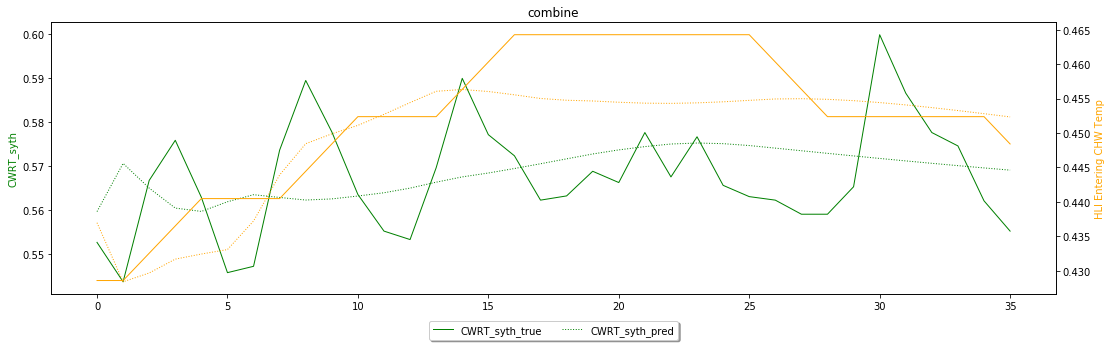

In [34]:
darray_3 = darray[1500]  # 100, 1500, 4930
pred_3 = getpredict(model_3, darray_3)

# plot
col = 'combine'
fig, ax1 = plt.subplots(figsize=(18, 5))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))

ax1.plot(darray_3[:, 0], c='green', linewidth=1, linestyle='-', label='CWRT_syth_true')
ax1.plot(pred_3[0, :, 0], c='green', linewidth=1, linestyle=':', label='CWRT_syth_pred')
ax1.set_ylabel('CWRT_syth', color='green')

ax2.plot(darray_3[:, 1], c='orange', linewidth=1, linestyle='-', label='HLI Entering CHW Temp_true')
ax2.plot(pred_3[0, :, 1], c='orange', linewidth=1, linestyle=':', label='HLI Entering CHW Temp_pred')
ax2.set_ylabel('HLI Entering CHW Temp', color='orange')

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
plt.title(col)
plt.show()

### __*predict all timestamps*__

In [35]:
data_impute_scale_daily_nomissing['pred_combine'] = data_impute_scale_daily_nomissing['data'].apply(
    lambda x: pd.DataFrame(getpredict(model_3, x[maincols+timecols].values)[0, :, :], 
                           columns=[maincols], index = x.index))
print(data_impute_scale_daily_nomissing.shape)
display(data_impute_scale_daily_nomissing.head())

(12660, 7)


,data,from,to,shape,CWRT_syth_missing,HLI Entering CHW Temp_missing,pred_combine
30,CWRT_syth HLI Entering C...,2019-01-13 02:30:00,2019-01-13 05:25:00,"(36, 4)",0.0,0.0,CWRT_syth HLI Entering CHW...
86,CWRT_syth HLI Entering C...,2019-01-13 07:10:00,2019-01-13 10:05:00,"(36, 4)",0.0,0.0,CWRT_syth HLI Entering CHW...
87,CWRT_syth HLI Entering C...,2019-01-13 07:15:00,2019-01-13 10:10:00,"(36, 4)",0.0,0.0,CWRT_syth HLI Entering CHW...
88,CWRT_syth HLI Entering C...,2019-01-13 07:20:00,2019-01-13 10:15:00,"(36, 4)",0.0,0.0,CWRT_syth HLI Entering CHW...
89,CWRT_syth HLI Entering C...,2019-01-13 07:25:00,2019-01-13 10:20:00,"(36, 4)",0.0,0.0,CWRT_syth HLI Entering CHW...


In [36]:
allpredictions = {}
for col in maincols:
    tmp = pd.concat(data_impute_scale_daily_nomissing['pred_combine'].apply(
        lambda x: x[col]).values, axis=1)
    tmp['mean'] = tmp.mean(axis=1)
    tmp['median'] = tmp.median(axis=1)
    tmp['std'] = tmp.std(axis=1)
    tmp['min'] = tmp.min(axis=1)
    tmp['max'] = tmp.max(axis=1)
    tmp['numpreds'] = tmp.count(axis=1)
    allpredictions[col] = tmp[['mean', 'median', 'min', 'max', 'std', 'numpreds']]
    
    print(allpredictions[col].shape)
    display(allpredictions[col].head())
    

(12940, 6)


,mean,median,min,max,std,numpreds
2019-01-13 02:30:00,0.188570,0.188570,0.0,0.188570,0.0,6
2019-01-13 02:35:00,0.170563,0.170563,0.0,0.170563,0.0,6
2019-01-13 02:40:00,0.177571,0.177571,0.0,0.177571,0.0,6
2019-01-13 02:45:00,0.186563,0.186563,0.0,0.186563,0.0,6
2019-01-13 02:50:00,0.192291,0.192291,0.0,0.192291,0.0,6


(12940, 6)


,mean,median,min,max,std,numpreds
2019-01-13 02:30:00,0.287139,0.287139,0.0,0.287139,0.0,6
2019-01-13 02:35:00,0.279297,0.279297,0.0,0.279297,0.0,6
2019-01-13 02:40:00,0.287732,0.287732,0.0,0.287732,0.0,6
2019-01-13 02:45:00,0.298730,0.298730,0.0,0.298730,0.0,6
2019-01-13 02:50:00,0.307877,0.307877,0.0,0.307877,0.0,6


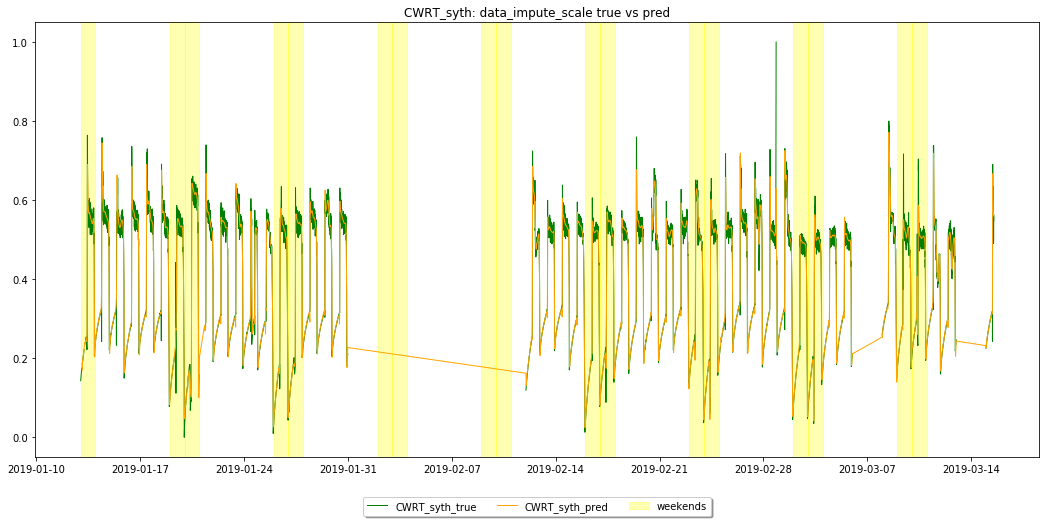

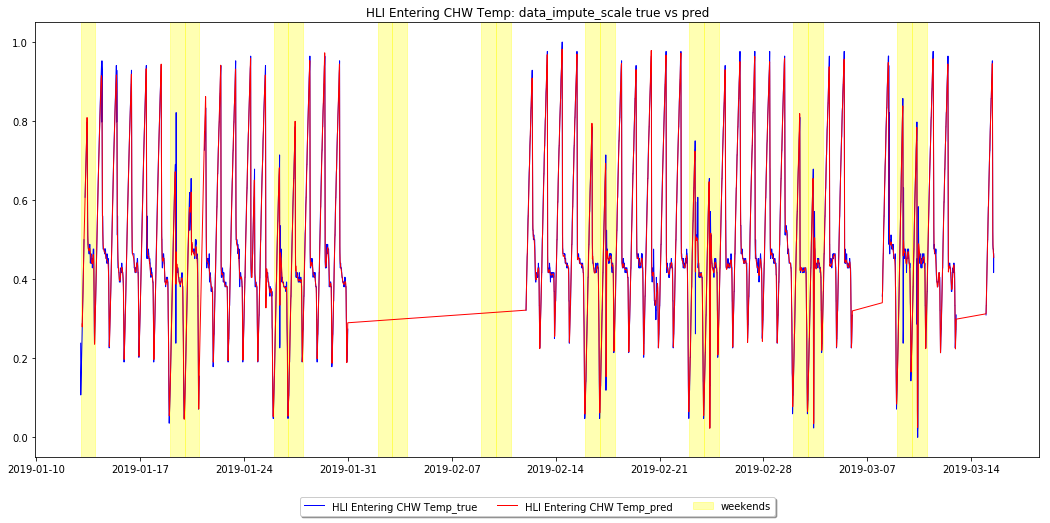

In [37]:
# ------------ compare true with pred ------------------
# plot

for col, clr in zip(['CWRT_syth', 'HLI Entering CHW Temp'], [['green', 'orange'], ['blue', 'red']]):
    
    plt.subplots(figsize=(18, 8))
    plt.plot_date(data_impute_scale.index, data_impute_scale[col], 
                  c=clr[0],  markersize=1,  marker='', linewidth=1, linestyle='-', label=col+'_true')
    plt.plot_date(allpredictions[col].index, allpredictions[col]['mean'].iloc[:, 0], 
                  c=clr[1],  markersize=1,  marker='', linewidth=1, linestyle='-', label=col+'_pred')
    
    tmp = data_impute_scale.index.to_frame()
    tmp['wkday'] = data_impute_scale.index.weekday+1
    tmp['date'] = tmp.index.date
    allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
    i = 0
    for dt in allwknddate:
        alltm_dt = tmp[str(dt)].index
        if i == len(allwknddate)-1:
            plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow', label='weekends')
        else:
            plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow')
        i += 1
    
    plt.title(col+': data_impute_scale true vs pred')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
    plt.show()

In [38]:
# rename and reindex allpredictions
for c in allpredictions.keys():
    allpredictions[c] = pd.DataFrame(allpredictions[c].to_records()).set_index('index')
    allpredictions[c].columns = [s.replace('(', '').replace(')', '').replace(',', '').replace("'", '')
                                 for s in list(allpredictions[c].columns)]
    

In [39]:
scaledscorediff = pd.concat([data_impute_scale[maincols]]+[allpredictions[c].rename(columns = {
    k: c+'_'+k for k in list(allpredictions[c])}) for c in allpredictions.keys()], axis=1)

for col in maincols:
    scaledscorediff[col+'-meanpred'] = scaledscorediff[col] - scaledscorediff[col+'_mean']
    scaledscorediff['abs('+col+'-meanpred)'] = abs(scaledscorediff[col+'-meanpred'])
    print('min({})={}'.format(col+'-meanpred', scaledscorediff[col+'-meanpred'].min()))
    print('max({})={}'.format(col+'-meanpred', scaledscorediff[col+'-meanpred'].max()))
    print('mean({})={}'.format(col+'-meanpred', scaledscorediff[col+'-meanpred'].mean()))
    print('std({})={}'.format(col+'-meanpred', scaledscorediff[col+'-meanpred'].std()))
              
print(scaledscorediff.shape)
display(scaledscorediff.head())


min(CWRT_syth-meanpred)=-0.17308003428976004
max(CWRT_syth-meanpred)=0.3699502944946289
mean(CWRT_syth-meanpred)=-0.0012275314735668416
std(CWRT_syth-meanpred)=0.020989322822807036
min(HLI Entering CHW Temp-meanpred)=-0.22779578173241477
max(HLI Entering CHW Temp-meanpred)=0.3612451717561598
mean(HLI Entering CHW Temp-meanpred)=0.0014217577137883245
std(HLI Entering CHW Temp-meanpred)=0.016530102940615635
(17719, 18)


,CWRT_syth,HLI Entering CHW Temp,CWRT_syth_mean,CWRT_syth_median,CWRT_syth_min,CWRT_syth_max,CWRT_syth_std,CWRT_syth_numpreds,HLI Entering CHW Temp_mean,HLI Entering CHW Temp_median,HLI Entering CHW Temp_min,HLI Entering CHW Temp_max,HLI Entering CHW Temp_std,HLI Entering CHW Temp_numpreds,CWRT_syth-meanpred,abs(CWRT_syth-meanpred),HLI Entering CHW Temp-meanpred,abs(HLI Entering CHW Temp-meanpred)
2019-01-13 00:00:00,0.143291,0.238095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-13 00:05:00,0.144571,0.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-13 00:10:00,0.146490,0.107143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-13 00:15:00,0.147769,0.111111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-13 00:20:00,0.149688,0.115079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


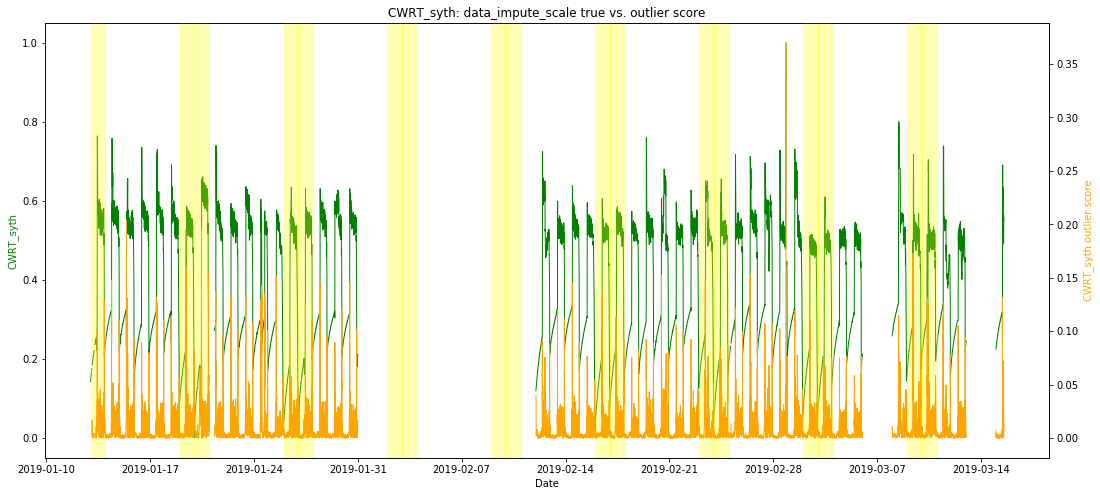

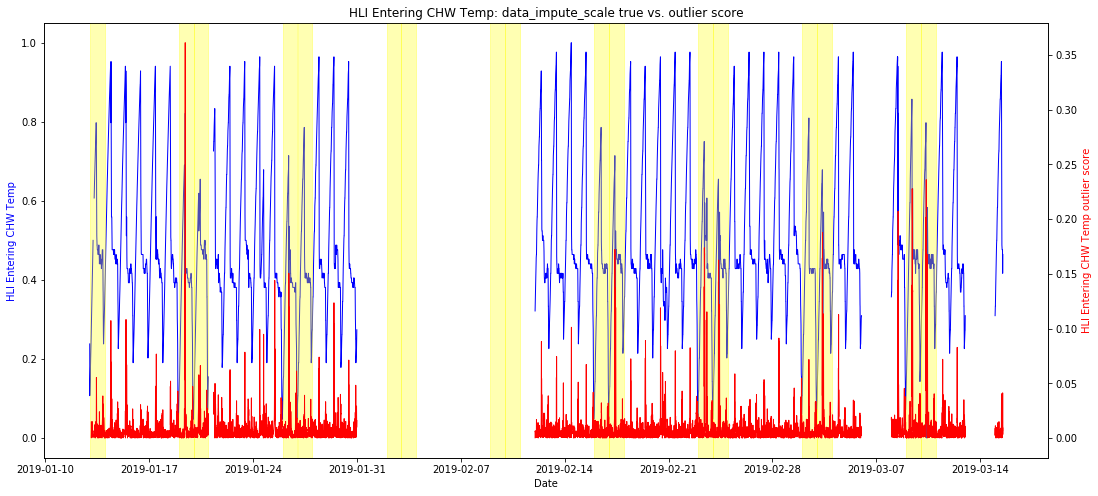

In [40]:
# ------------ outlier score plot ------------------
for col, clr in zip(maincols, [['green', 'orange'], ['blue', 'red']]):
    fig, ax1 = plt.subplots(figsize=(18, 8))
    ax2 = ax1.twinx()
    ax2.spines['right'].set_position(('axes', 1))
    
    ax1.plot_date(data_impute_scale.index, data_impute_scale[col], 
                  c=clr[0],  markersize=1,  marker='', linewidth=1, linestyle='-')
    ax1.set_ylabel(col, color=clr[0])
    ax1.set_xlabel('Date')
    
    ax2.plot_date(scaledscorediff.index, scaledscorediff['abs('+col+'-meanpred)'], 
                  c=clr[1],  markersize=1,  marker='', linewidth=1, linestyle='-')
    ax2.set_ylabel(col+' outlier score', color=clr[1])
    ax2.set_xlabel('Date')

    tmp = data_impute_scale.index.to_frame()
    tmp['wkday'] = data_impute_scale.index.weekday+1
    tmp['date'] = tmp.index.date
    allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
    i = 0
    for dt in allwknddate:
        alltm_dt = tmp[str(dt)].index
        if i == len(allwknddate)-1:
            plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow', label='weekends')
        else:
            plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow')
        i += 1
    
    plt.title(col+': data_impute_scale true vs. outlier score')
    plt.show()